In [173]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [174]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import sys
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import scipy.stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [175]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 10})
plt.rc('font', family='serif')

####################################################################################################################################################################################

## [0] Load in Hs from *TopDis (spacer length = 4)* for INDELs, and get top 10 HTs & top 10 SSRs

####################################################################################################################################################################################

In [200]:
#load in INDELs
all_homoplasic_INDELs = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/INDEL homoplasies/homoplasy_count_across_lineages_spacer_4.pkl')

In [201]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,1,2,3,4A,4B,4C,5,6,total,num_isolates
47371,4408100,GC,G,Antibiotic Resistance,gid,Rv3919c,103,del,frameshift,35,...,41.0,27.0,51.0,43.0,11.0,29.0,0.0,0.0,202.0,388
47365,4408087,CG,C,Antibiotic Resistance,gid,Rv3919c,116,del,frameshift,39,...,23.0,11.0,35.0,33.0,10.0,18.0,0.0,0.0,130.0,212
47313,4407851,GC,G,Antibiotic Resistance,gid,Rv3919c,352,del,frameshift,118,...,21.0,9.0,40.0,20.0,6.0,19.0,0.0,0.0,115.0,182
25151,2288850,A,ACC,Antibiotic Resistance,pncA,Rv2043c,392,ins,frameshift,131,...,1.0,14.0,6.0,3.0,6.0,2.0,0.0,0.0,32.0,48
47315,4407851,G,GC,Antibiotic Resistance,gid,Rv3919c,352,ins,frameshift,118,...,5.0,1.0,12.0,5.0,7.0,1.0,0.0,0.0,31.0,52


In [202]:
np.shape(all_homoplasic_INDELs)

(46306, 22)

Note - SNPs & INDELs with homoplasy score $ = 0$ were dropped from DataFrames

#### mark *mmpR* (Rv0678) as an Antibiotic Resistance gene

In [203]:
all_homoplasic_INDELs.loc[all_homoplasic_INDELs['gene_id'] == 'Rv0678', 'gene_category'] = 'Antibiotic Resistance'
all_homoplasic_INDELs.loc[all_homoplasic_INDELs['gene_id'] == 'Rv0678', 'gene_name'] = 'mmpR'

all_homoplasic_INDELs.loc[all_homoplasic_INDELs['gene_id'] == 'Rv3696c', 'gene_category'] = 'Antibiotic Resistance'

####################################################################################################################################################################################

## [1] Separate INDELs into those occcurring in HT regions, SSR regions and those not in either

####################################################################################################################################################################################

### [1.1] HT

In [204]:
homopolymeric_regions_from_Luca = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/comparison_with_homopolymeric_regions/homopolymer regions from Luca/list_homopolymers_7bpmore_pure.csv')

**Note 1:** Luca's scheme starts at -1bp relative to the HT track since that's where variants are usually called

**Note 2:** two HT regions in *PPE13* are located right next to eachother, change chromEnd position of the *TTTTTTTT* HT so we don't double count indels

In [205]:
homopolymeric_regions_from_Luca[homopolymeric_regions_from_Luca.gene_name == 'PPE13']

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name
80,NC_000962.3,976889,976897,TTTTTTTT,Rv0878c,PPE13
103,NC_000962.3,976897,976906,GGGGGGGGG,Rv0878c,PPE13


In [206]:
homopolymeric_regions_from_Luca.loc[80,'chromEnd'] = 976896

create a set of all Reference Positions that occur within a Homopolymeric Tract

In [207]:
all_HT_ref_postions = []
for HT_i_start, HT_i_end in zip(homopolymeric_regions_from_Luca.chromStart, homopolymeric_regions_from_Luca.chromEnd):
    
    HT_i_ref_positions = range(HT_i_start, HT_i_end+1)
    all_HT_ref_postions = all_HT_ref_postions + HT_i_ref_positions
    
all_HT_ref_postions = set(all_HT_ref_postions)

In [208]:
len(all_HT_ref_postions)

1160

### [1.2] Annotate each INDEL based on whether it is in an HT or other

iterate through all INDELs and figure out which occur in SSR and those that don't

In [209]:
repeat_region_list = []
for indel_i_pos in all_homoplasic_INDELs.pos:
    
    if indel_i_pos in all_HT_ref_postions:
        repeat_region_list.append('HT')
    
    else:
        repeat_region_list.append('no')
        
all_homoplasic_INDELs.loc[:,'repeat_region'] = repeat_region_list

In [210]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
47371,4408100,GC,G,Antibiotic Resistance,gid,Rv3919c,103,del,frameshift,35,...,27.0,51.0,43.0,11.0,29.0,0.0,0.0,202.0,388,no
47365,4408087,CG,C,Antibiotic Resistance,gid,Rv3919c,116,del,frameshift,39,...,11.0,35.0,33.0,10.0,18.0,0.0,0.0,130.0,212,no
47313,4407851,GC,G,Antibiotic Resistance,gid,Rv3919c,352,del,frameshift,118,...,9.0,40.0,20.0,6.0,19.0,0.0,0.0,115.0,182,no
25151,2288850,A,ACC,Antibiotic Resistance,pncA,Rv2043c,392,ins,frameshift,131,...,14.0,6.0,3.0,6.0,2.0,0.0,0.0,32.0,48,no
47315,4407851,G,GC,Antibiotic Resistance,gid,Rv3919c,352,ins,frameshift,118,...,1.0,12.0,5.0,7.0,1.0,0.0,0.0,31.0,52,no


In [211]:
all_homoplasic_INDELs.shape

(46306, 23)

####################################################################################################################################################################################

## [2] Aggregate INDELs by HT region (all bp lengths)

####################################################################################################################################################################################

### [2.1] HTs

In [212]:
homopolymeric_regions_from_Luca.head()

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name
0,NC_000962.3,36470,36477,CCCCCCC,Rv0032,bioF2
1,NC_000962.3,71453,71460,CCCCCCC,Rv0064,Rv0064
2,NC_000962.3,191391,191398,CCCCCCC,Rv0161,Rv0161
3,NC_000962.3,238807,238814,CCCCCCC,Rv0202c,mmpL11
4,NC_000962.3,587728,587735,CCCCCCC,Rv0497,Rv0497


In [213]:
homopolymeric_regions_from_Luca.shape

(145, 6)

In [214]:
# subset to INDELs that occur within HT regions
HT_homoplasic_INDELs = all_homoplasic_INDELs[all_homoplasic_INDELs.repeat_region == 'HT']

# further subset to frameshift HT indels
HT_homoplasic_frameshifts = HT_homoplasic_INDELs[HT_homoplasic_INDELs.INDEL_type == 'frameshift']

In [215]:
HT_homoplasic_INDELs.shape

(330, 23)

In [216]:
HT_homoplasic_frameshifts.shape

(294, 23)

### skip below on first run

############################################################################################################

#### sort variants by top *Hs* and keep only a single bp variants

In [217]:
bp_length_diff = HT_homoplasic_INDELs.ref.apply(len) - HT_homoplasic_INDELs.alt.apply(len)
single_bp_ins_del_filter = [(x==-1)|(x==1) for x in bp_length_diff]
HT_homoplasic_INDELs = HT_homoplasic_INDELs[single_bp_ins_del_filter]

In [218]:
HT_homoplasic_INDELs.shape

(204, 23)

In [219]:
bp_length_diff = HT_homoplasic_frameshifts.ref.apply(len) - HT_homoplasic_frameshifts.alt.apply(len)
single_bp_ins_del_filter = [(x==-1)|(x==1) for x in bp_length_diff]
HT_homoplasic_frameshifts = HT_homoplasic_frameshifts[single_bp_ins_del_filter]

In [220]:
HT_homoplasic_frameshifts.shape

(204, 23)

############################################################################################################

#### Tally the number of *frameshifts* that occur in each coding HT and *INDELs* that occur in each intergenic HT

In [221]:
num_INDEL_homoplasies_list = []
num_isolates_with_INDEL_list = []
num_variants_in_HT_list = []

#iterate through each homopolymeric region
for chromsStart_i , chromEnd_i, locus_tag_i in zip(homopolymeric_regions_from_Luca.chromStart, homopolymeric_regions_from_Luca.chromEnd, homopolymeric_regions_from_Luca.locus_tag):
    
    #define a list of H37Rv coordinates that corresponds to this homopolymeric region (- 1 bp already accounted for in HT dataframe)
    homopolymeric_region_i_coords = np.arange(chromsStart_i, chromEnd_i + 1)
    
    # HT located in CODING region
    if (('inter' not in locus_tag_i) and ('nc' not in locus_tag_i)):

        # Frameshifts
        #create a filter for Frameshifts that occur in this region
        homoplasy_INDEL_filter = np.array( [INDEL_i_pos in homopolymeric_region_i_coords for INDEL_i_pos in HT_homoplasic_frameshifts.pos] )

        #count number of homoplasy INDELs in regions and store in list
        num_INDEL_homoplasies_list.append(HT_homoplasic_frameshifts[homoplasy_INDEL_filter].total.astype(float).sum())

        #count the number of isolates that have an INDEL in region and store in list
        num_isolates_with_INDEL_list.append(HT_homoplasic_frameshifts[homoplasy_INDEL_filter].num_isolates.astype(float).sum())
        
        # count the number of variants detected in this HT
        num_variants_in_HT_list.append(HT_homoplasic_frameshifts[homoplasy_INDEL_filter].shape[0])
        
    # HT located in Non-Coding region (ncRNA or intergenic)
    else:
        
        # INDELs
        #create a filter for INDELs that occur in this region
        homoplasy_INDEL_filter = np.array( [INDEL_i_pos in homopolymeric_region_i_coords for INDEL_i_pos in HT_homoplasic_INDELs.pos] )

        #count number of homoplasy INDELs in regions and store in list
        num_INDEL_homoplasies_list.append(HT_homoplasic_INDELs[homoplasy_INDEL_filter].total.astype(float).sum())

        #count the number of isolates that have an INDEL in region and store in list
        num_isolates_with_INDEL_list.append(HT_homoplasic_INDELs[homoplasy_INDEL_filter].num_isolates.astype(float).sum())
        
        # count the number of variants detected in this HT
        num_variants_in_HT_list.append(HT_homoplasic_INDELs[homoplasy_INDEL_filter].shape[0])
    
#append lists to DataFrame of homopolymeric regions
homopolymeric_regions_from_Luca.loc[: , 'INDEL_homoplasy'] = num_INDEL_homoplasies_list
homopolymeric_regions_from_Luca.loc[: , 'num_isolates_with_INDEL'] = num_isolates_with_INDEL_list
homopolymeric_regions_from_Luca.loc[: , 'unique_variants_in_HT'] = num_variants_in_HT_list
## homopolymeric_regions_from_Luca.sort_values(by = 'INDEL_homoplasy' , ascending = False, inplace = True)
## homopolymeric_regions_from_Luca.reset_index(inplace=True,drop=True)

#convert datatypes from float > int
convert_dict = {'INDEL_homoplasy':int, 'num_isolates_with_INDEL':int}
homopolymeric_regions_from_Luca = homopolymeric_regions_from_Luca.astype(convert_dict)

In [222]:
homopolymeric_regions_from_Luca.head(n=10)

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name,INDEL_homoplasy,num_isolates_with_INDEL,unique_variants_in_HT
0,NC_000962.3,36470,36477,CCCCCCC,Rv0032,bioF2,131,4888,2
1,NC_000962.3,71453,71460,CCCCCCC,Rv0064,Rv0064,0,0,0
2,NC_000962.3,191391,191398,CCCCCCC,Rv0161,Rv0161,72,273,2
3,NC_000962.3,238807,238814,CCCCCCC,Rv0202c,mmpL11,1,2,1
4,NC_000962.3,587728,587735,CCCCCCC,Rv0497,Rv0497,0,0,0
5,NC_000962.3,644504,644511,CCCCCCC,Rv0553,menC,0,0,0
6,NC_000962.3,691887,691894,CCCCCCC,Rv0592,mce2D,94,4843,2
7,NC_000962.3,799136,799143,CCCCCCC,Rv0698,Rv0698,80,4224,2
8,NC_000962.3,854252,854261,CCCCCCCCC,inter_Rv0759c_Rv0760c,inter_Rv0759c_Rv0760c,322,24880,2
9,NC_000962.3,912694,912701,CCCCCCC,inter_Rv0819_Rv0820,inter_mshD_phoT,26,148,2


In [223]:
homopolymeric_regions_from_Luca.shape

(145, 9)

How many HTs have no **Hs**?

In [224]:
sum(homopolymeric_regions_from_Luca.unique_variants_in_HT == 0)

54

How many HTs have multi-allelic variants?

In [225]:
sum(homopolymeric_regions_from_Luca.unique_variants_in_HT == 1)

8

In [226]:
sum(homopolymeric_regions_from_Luca.unique_variants_in_HT > 1) # variants within an HT at DIFFERENT sites

83

### Run code above once for x and again for y including the special block of code to filter for only 1bp INDELs

Save series with all variants to compare with series with just top Hs variant per site (and re-run code above)

In [199]:
HT_Hs_series_x = homopolymeric_regions_from_Luca.INDEL_homoplasy # aggregate of Hs across all variants

In [227]:
HT_Hs_series_y = homopolymeric_regions_from_Luca.INDEL_homoplasy # only 1bp insertions/deletions

Plot aggegrate Hs per HT below

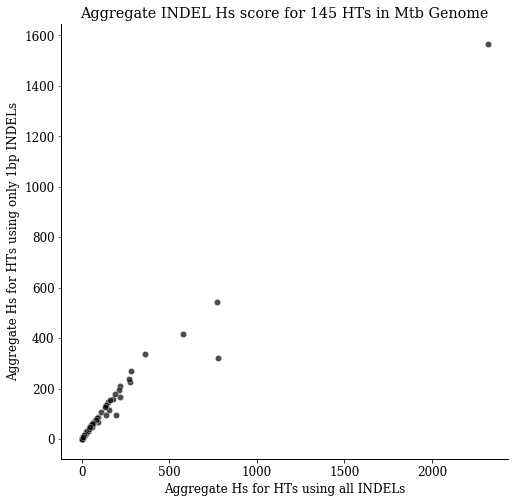

In [254]:
fig, ax = plt.subplots()

ax.scatter(HT_Hs_series_x, HT_Hs_series_y, color = 'k', linewidth=0.5, edgecolor='white', s = 40, alpha=0.7)

ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Aggregate Hs for HTs using only 1bp INDELs', color = 'k')
ax.set_xlabel('Aggregate Hs for HTs using all INDELs', color = 'k')
ax.set_title('Aggregate INDEL Hs score for 145 HTs in Mtb Genome', color = 'k')

fig = plt.gcf()
fig.set_size_inches(8.0, 8.0)

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/for publication/PNAS_reviews/Hs_scores_for_HTs_1bp_vs_all_INDEL_compare.png'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = False)

plt.show()